# Processing the data:

Once all the data is acquired, the five scans of each case (dark, mirror, L, C, R) should be averaged element wise, these new arrays need to be “cleaned”. The data taken with no sample in place needs to be subtracted from the sample data element wise, this plot should have the edges near zero. Then the data taken with the empty sapphire substrate should be divided from the thin film data element wise, need to ensure zero divisions are handled properly (return zero). Leaving our final result, which should have some oscillation or at least a peak. 

## import necessary Libraries


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.stats import chi2
import warnings
import os as os


# Load data from file into array


In [118]:
# variables containing string of filepaths
# only need to change path here, and change name of output figure
filepath_data='H1168/H1168R.txt'
filepath_blank='H1168/BLANK.txt'
filepath_std='H1168/STD.txt'
#load in all necessary data, since background and noise data is needed
data_in = np.genfromtxt(filepath_data, skip_header=6, delimiter='	')
blankARraw = np.genfromtxt(filepath_blank, skip_header = 6, delimiter = '	')
std_corrARraw = np.genfromtxt(filepath_std, skip_header = 6, delimiter = '	')

In [119]:
#enter columns into 1d arrays
wavel = data_in[:,1][800:3000] ##wavel contains x values
image1 = data_in[:,-1][800:3000]
image2 = data_in[:,-2][800:3000]
image3 = data_in[:,-3][800:3000]
image4 = data_in[:,-4][800:3000]
image5 = data_in[:,-5][800:3000]
blankAR1 = blankARraw[:,-1][800:3000]
blankAR2 = blankARraw[:,-2][800:3000]
blankAR3 = blankARraw[:,-3][800:3000]
blankAR4 = blankARraw[:,-4][800:3000]
blankAR5 = blankARraw[:,-5][800:3000]
std_corrAR1 = std_corrARraw[:,-1][800:3000]
std_corrAR2 = std_corrARraw[:,-2][800:3000]
std_corrAR3 = std_corrARraw[:,-3][800:3000]
std_corrAR4 = std_corrARraw[:,-4][800:3000]
std_corrAR5 = std_corrARraw[:,-5][800:3000]

##average over 5 spectra
image = np.mean([image1,image2,image3,image4,image5],axis = 0) ## y values
blankAR = np.mean([blankAR1,blankAR2,blankAR3,blankAR4,blankAR5],axis = 0) ## to be subtracted
std_corrAR = np.mean([std_corrAR1,std_corrAR2,std_corrAR3,std_corrAR4,std_corrAR5],axis = 0) - blankAR ## to be divided


# Subtract background and divide reflectivity


In [120]:
#this should take the data at the edges to zero
nobackground = image - blankAR


##this is now data with no background, and with the empty sapphire substrate divided out
final = np.divide(nobackground,std_corrAR, out = np.zeros_like(nobackground), where = std_corrAR != 0)

## Plot raw data (before correction) with a solid line


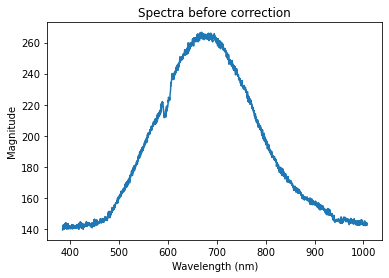

In [128]:
plt.plot(wavel,image, '-');

# Set axis limits
#plt.xlim(100,1200)
#plt.ylim(0,1550);

# Add axis labels
plt.xlabel('Wavelength (nm)')
plt.ylabel('Magnitude');


# Add title
plt.title('Spectra before correction');

# Plot cleaned data with a solid line


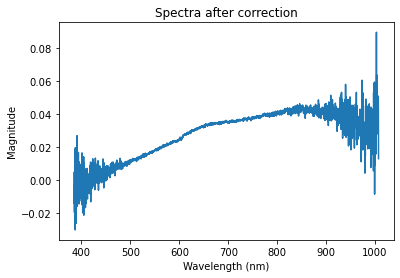

In [129]:
plt.plot(wavel,final, '-');

# Set axis limits 
#plt.xlim(450,850)
#plt.ylim(0,1);

# Add axis labels
plt.xlabel('Wavelength (nm)')
plt.ylabel('Magnitude');

# Add legend
## plt.legend(['Data','100 $\Omega$'])

# Add title
plt.title('Spectra after correction');

# Fitting to the data:

Once only the thin film data is left, fit using the following equation: $$R=A+Bcos(\frac{4π}{\lambda}*nd),$$ where the wavelength lambda is the independent variable. $D$ is the thickness of the thin film, $A$ is a vertical shift, and $B$ is the amplitude. The python notebook does all of this, however you need to add the text files, and indicate their file path at the beginning. To fit the model to the data, it is good practice to first plot a manual fit over the data to find good initial parameter guesses. Also determine what range you wish to fit within, avoid fitting to any data that is too noisy, or different from the range of interest. To get a numerical idea of the quality of the fit, the $R^2$ is calculated, the closer to $1$ the stronger the fit. If the fit fails, reconsider the range of data used, or change the initial guesses of the parameters. The main parameter we are interested in is $d$, meaning the real focus of the fit should be on the frequency, so if the amplitudes are a little bit off, that is not uncommon for this model as it ignores absorption. If desired a damping factor could be added to model to account for this. 

## Polynomial fit

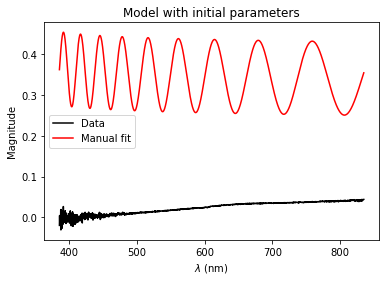

In [125]:
## try adding polynomial factor to account for curve
def polymodel(x,a,b,d,p,s):
    n = 2.39*4*np.pi    
    return (((x+s)**(p)))+(a+(b * np.cos(d*(n/x))))

## a and b are constants, d is thickness, x is wavelength, n is refractive index of material, \
## f and p are polynomial to account for edge behavior

## set range for fit 
xvals = wavel[:1600]
yvals = final[:1600]
## set initial param. values below based on existing data 2018-2019

ainit = -.6
binit =-.09
dinit = 1350
pinit = -.01
sinit = -350
## index depends on material (2.39 used in existing data 2018-2019)
polyinit = [ainit,binit,dinit,pinit,sinit]
## plot model with inital parameters
plt.plot(xvals,yvals, 'k-', label = 'Data');
plt.plot(xvals, polymodel(xvals,polyinit[0],polyinit[1],polyinit[2],polyinit[3],polyinit[4]), 'r-', label = 'Manual fit');

# Label axes and give it a title for notebook (remove it when including the plot in a report)
plt.xlabel('$\\lambda$ (nm)')
plt.ylabel('Magnitude')
plt.title('Model with initial parameters')
plt.legend()
plt.show()


<ipython-input-125-9ebbc99a0098>:4: RuntimeWarning: invalid value encountered in power
  return (((x+s)**(p)))+(a+(b * np.cos(d*(n/x))))


a =  -1.2293688908531721 +/- 0.011655950749689213
b =  -0.00036645431282661124 +/- 0.00012130153299802681
Thickness =  1362.3142034779812 +/- 6.210406786924121 nm
p =  0.03708989325043863 +/- 0.0012779021849863104
s =  -153.89566132801855 +/- 17.392108164875133


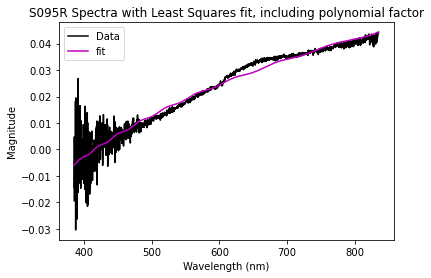

In [126]:
pOpt, pVar = curve_fit(polymodel,xvals,yvals, p0 = polyinit)
pErr = np.sqrt(np.diag(pVar))
print ("a = ", pOpt[0], '+/-', pErr[0])
print ("b = ", pOpt[1], '+/-', pErr[1])
print ("Thickness = ", pOpt[2], '+/-', pErr[2], "nm")
print ("p = ", pOpt[3], '+/-', pErr[3])
print ("s = ", pOpt[4], '+/-', pErr[4])

## plot manual fit on top of data
fit = polymodel(xvals,pOpt[0],pOpt[1],pOpt[2],pOpt[3],pOpt[4]) ## need to remember it has as many points as yvals
plt.plot(xvals,yvals, 'k-', label = 'Data');

plt.plot(xvals, fit, 'm-', label = 'fit');


# Set axis limits to include origin
#plt.xlim(350,1050)


# Add axis labels
plt.xlabel('Wavelength (nm)')
plt.ylabel('Magnitude');

# Add legend
plt.legend()

# Add title
plt.title('S095R Spectra with Least Squares fit, including polynomial factor');

## Declare model fitting function and plot initial parameters


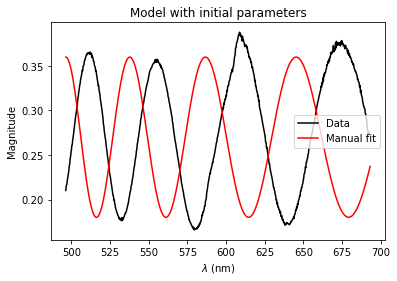

In [52]:
## x needs to be first parameter!!!
def model(x,a,b,d):
    n = 2.39*4*np.pi    
    return a+(b * np.cos(d*(n/x)))

## a and b are constants, d is thickness, x is wavelength, n is refractive index of material (2.39?)

## set range for fit 
xvals = wavel[400:1100]
yvals = final[400:1100]
## set initial param. values below based on existing data 2018-2019

ainit = .27
binit =.09
dinit = 1350
## index depends on material (2.39 used in existing data 2018-2019)
pinit = [ainit,binit,dinit]
## plot model with inital parameters
plt.plot(xvals,yvals, 'k-', label = 'Data');
plt.plot(xvals, model(xvals,pinit[0],pinit[1],pinit[2]), 'r-', label = 'Manual fit');

# Label axes and give it a title for notebook (remove it when including the plot in a report)
plt.xlabel('$\\lambda$ (nm)')
plt.ylabel('Magnitude')
plt.title('Model with initial parameters')
plt.legend()
plt.show()


## Perform fit and plot over data

a =  0.27280395149002473 +/- 0.0003583881045241848
b =  -0.09775060031692655 +/- 0.0005139096250301944
Thickness =  1337.3118145225128 +/- 0.0991152747630142 nm


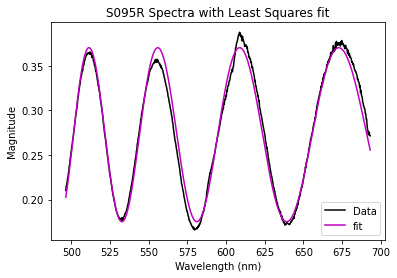

In [48]:
pOpt, pVar = curve_fit(model,xvals,yvals, p0 = pinit)
pErr = np.sqrt(np.diag(pVar))
print ("a = ", pOpt[0], '+/-', pErr[0])
print ("b = ", pOpt[1], '+/-', pErr[1])
print ("Thickness = ", pOpt[2], '+/-', pErr[2], "nm")

## plot manual fit on top of data
fit = model(xvals,pOpt[0],pOpt[1],pOpt[2]) ## need to remember it has as many points as yvals
plt.plot(xvals,yvals, 'k-', label = 'Data');

plt.plot(xvals, fit, 'm-', label = 'fit');


# Set axis limits to include origin
#plt.xlim(350,1050)


# Add axis labels
plt.xlabel('Wavelength (nm)')
plt.ylabel('Magnitude');

# Add legend
plt.legend()

# Add title
plt.title('S095R Spectra with Least Squares fit');
#plt.text(500,.0,'d = 1284.5 +/- 0.1 nm')
#plt.text(500,.03,'R^2 = 0.9647')
plt.savefig('S095/AL_wafer/fit.pdf')


## Compute Residuals and plot


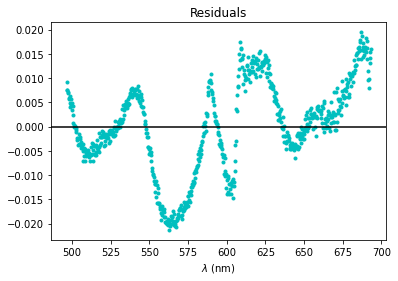

In [49]:
residuals = yvals - fit

plt.plot(xvals, residuals, 'c.')
plt.title('Residuals')
plt.xlabel('$\lambda$ (nm)')
plt.axhline(y=0.0, color='k', linestyle='-')
plt.show()
##not sure these apply here, fit was non linear least squares

## Compute Coefficient of Determination

In [50]:
res_sum_sq = np.sum(residuals**2)
tot_sum_sq = np.sum((yvals - np.mean(yvals))**2)

r_sq = 1 - (res_sum_sq/tot_sum_sq)

print(r_sq)

0.9811134850233308
